# Lab 6: Deep Neural Network

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.io import wavfile
from scipy import signal
from tqdm.notebook import tqdm
import tensorflow.keras.backend as K
from tensorflow.keras import datasets, layers, models, optimizers
from sklearn.preprocessing import OneHotEncoder
import IPython.display as ipd

### Load the meta files for train and test dataset

The meta data can be loaded as a ``pandas.DataFrame`` in Python, where each row coresponds to one bird call/chatter recording. Each recording corresponds to a bird usually found in PNW. The bird names are in shortcodes found in https://ebird.org. 

In [3]:
# load train and test meta data
# change path according to your directory structure
train_path = './data/train.csv'
train_df = pd.read_csv(train_path)
test_path = './data/test.csv'
test_df = pd.read_csv(test_path)
# sampling frequency we will use
FS = 22050
# duration of each sound
T =20
# display train dataset
train_df

file     bird
0     XC212943   bewwre
1     XC377560   houspa
2     XC313351   amerob
3     XC188131   whcspa
4     XC340598  mallar3
...        ...      ...
1674  XC193112   amecro
1675  XC481270   rethaw
1676  XC368449   rewbla
1677  XC153552   amegfi
1678  XC294256   amegfi

[1679 rows x 2 columns]

In [4]:
#The ebird codes from ebird.org
LABELS=["amecro","amegfi","amerob","annhum","bewwre","bkcchi"
                             ,"cangoo","comrav","daejun","doccor","grbher3","houfin","houspa",
                             "mallar3","norfli","rebnut","rethaw","rewbla","sonspa","spotow",
                                "stejay","whcspa"]
#Encoder that does the one-hot bit encoding
encoder = OneHotEncoder(sparse=False).fit(np.array(LABELS).reshape(-1,1))


/Users/wmhst7/miniconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Load the train and test dataset

#### Task 1 (6 points)
1.  Use the function ``load_dataset()`` (with parameters ``transform = None`` ) to load train and test dataset. The code for loading the train dataset is already provided in the starter code. You still have to write the code line for loading the test dataset (this is an easy task). ``load_dataset()`` returns a tuple ``(data, labels)``, where ``data`` contains the audio time series organized in a 2D numpy array and ``labels`` contains the labels (One-hot bit encoding of ``ebird_code``) for each audio sample. Each label consists of an array of size 22 with 21 zeros and a single '1' at the position corresponding to the bird type. Each row of ``data`` is a single bird recording and the corresponding row in ``labels`` is the corresponding bird. That is, the audio time series and label of the i-th recording can be accessed by ``audio = data[i]`` and ``label = labels[i]``. 
2. Plot the time series of a single recording using ``plt.plot()`` and play the bird using the ``IPython.display`` function from Lab 1. You can display recording i = 0, 150, 250, 350. The x-axis of your plot should be in seconds. Make sure to label both x- and y-axis properly. Print the label (ideally the ebird code) of the corresponding recording.

In [5]:
def load_dataset(path_dataset, path_meta, transform='none', downsample=True):
    """
    path_dataset : str
        path of the folder tht contains the audio samples
    path_meta : str
        path of the metadata file corresponding to the dataset
    transform : str
        'none' for no transform of the data or 'spec' for transforming the data into spectrograms
    downsample : bool
        If True, the audio recording will be downsampled to a frequency of 11025 Hz.
    """
    dataset_meta = pd.read_csv(path_meta)
        
    labels = dataset_meta['bird'].copy()
    labels = encoder.transform(np.array(labels).reshape(-1,1))
    if transform != 'spec':
        audio = np.zeros((len(dataset_meta.file), FS*T,),np.float32)
    else:
        audio = np.zeros((len(dataset_meta.file), 513,int(FS*T/1024)),np.float32)
    i=0
    for file in tqdm(dataset_meta.file):
        fs, audio_single = wavfile.read(path_dataset + file + '.wav')
        audio_single = audio_single[:2*FS*T]
        audio_single =  signal.resample_poly(audio_single*1., 1, 2)[:20*22050]
        audio_single = audio_single / np.max(abs(audio_single)) 
        audio_single = np.pad(audio_single, (0,22050*20-len(audio_single)))
        if transform == 'spec':
            f, t, audio_single = spec2(audio_single, N=1024) #if you cannot finish assignment 3, replace spec by spec2
        audio[i] = audio_single
        i+=1
            
#     audio = np.array(audio)
    if transform == 'spec':
        dim1 = audio.shape[0]
        dim2 = audio.shape[1]
        dim3 = audio.shape[2]
        
        audio = audio.reshape(dim1, dim2, dim3, 1)

    return audio, labels


In [12]:
# load datasets
data_train, labels_train = load_dataset('data/train/', 'data/train.csv', transform=None)
# Load the test dataset onto data_test and labels_test variables
data_test, labels_test = load_dataset('data/test/', 'data/test.csv', transform=None)

  0%|          | 0/1679 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

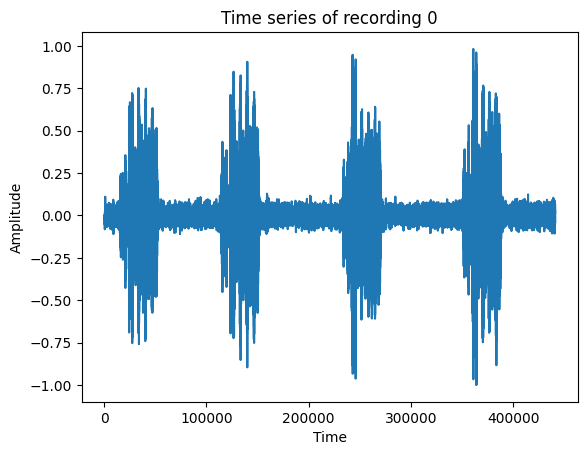

Label of data_train[i] where i= 0 is 4


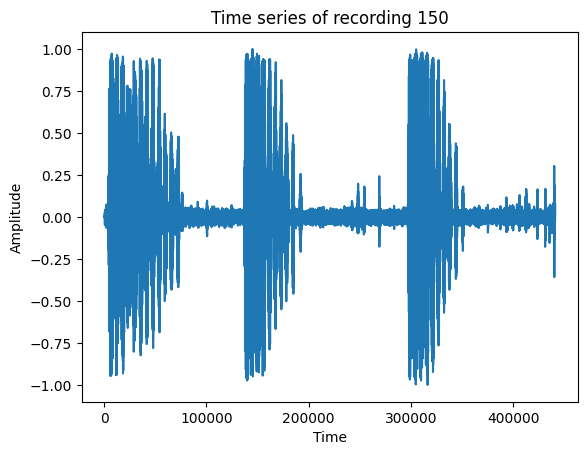

Label of data_train[i] where i= 150 is 13


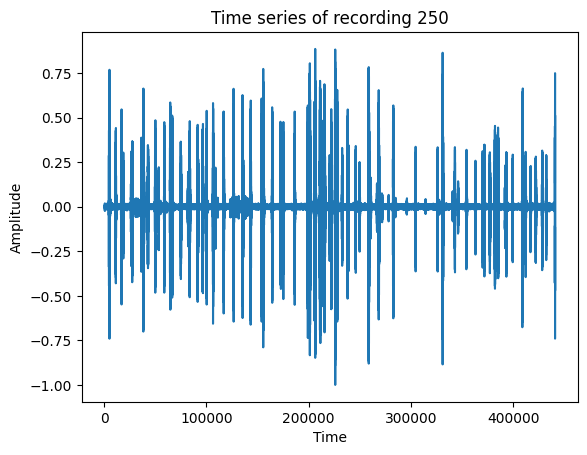

Label of data_train[i] where i= 250 is 17


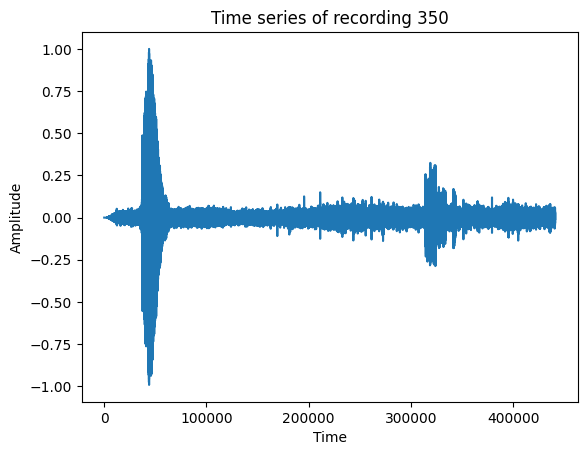

Label of data_train[i] where i= 350 is 16


In [13]:
for i in [0, 150, 250, 350]:
    # TODO: plot time series of a single recording from the training set
    plt.figure()
    plt.plot(data_train[i])
    plt.title(f'Time series of recording {i}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()
    
    # TODO: print its label (Hint: use np.where())
    print("Label of data_train[i] where i=", i, 'is', np.where(labels_train[i] == 1)[0][0])
    
    # TODO: play the recording
    ipd.display(ipd.Audio(data_train[i], rate=22050))

## A Naive Deep learning Implementation

#### Task 2a: (2 points)
Add at least two additional ``Dense`` layers to the network architecture in the starter code.
You are free to chose the number of neurons, and activation function in each layer.

In [14]:
# model for raw time series data
model = models.Sequential() # groups a linear stack of layers into a tensorflow.keras.Model, basically this builds your model framework

model.add(layers.Dense(100, activation='relu',input_shape=data_train[0].shape))

# TODO add at least 2 more layers to the network
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(22, activation='sigmoid'))
# No need to call build() as the input_shape is already defined in the first layer
model.summary()

/Users/wmhst7/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │    44,100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 22)             │           726 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,109,370 (168.26 MB)

 Trainable params: 44,109,370 (168.26 MB)

 Non-trainable params: 0 (0.00 B)

#### Task 2b: (2 points)
Run the model fitting and describe (in words in a separate markdown cell), how the classification accuracy on the train and test set changes throughout the model training.
Plot train and test set accuracy as a function of epoch number and report the final accuracy on the test set. (The code for that is already provided and all you have to do is execute it.)
Assume, you have a new bird sound sample that the model has not seen before.
How likely do you think is it that the model identifies the right bird.
Comment on that in the notebook.

In [15]:
# compile the model and fit it to the training data
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(data_train, np.array(labels_train), epochs=10, validation_data=(data_test, np.array(labels_test)), shuffle=True)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.0516 - loss: 0.5948 - val_accuracy: 0.0476 - val_loss: 0.2879
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.2320 - loss: 0.7591 - val_accuracy: 0.0595 - val_loss: 0.4440
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.7603 - loss: 0.1100 - val_accuracy: 0.0690 - val_loss: 0.4143
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.9389 - loss: 0.0428 - val_accuracy: 0.0643 - val_loss: 0.3871
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9850 - loss: 0.0236 - val_accuracy: 0.0738 - val_loss: 0.3735
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.9909 - loss: 0.0145 - val_accuracy: 0.0810 - val_loss: 0.3596
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.9971 - loss: 0.0102 - val_accuracy: 0.0690 - val_loss: 0.3522
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.9987 - loss: 0.0072 - val_accuracy:

14/14 - 0s - 16ms/step - accuracy: 0.0738 - loss: 0.3313
test accuracy is :  0.07380952686071396


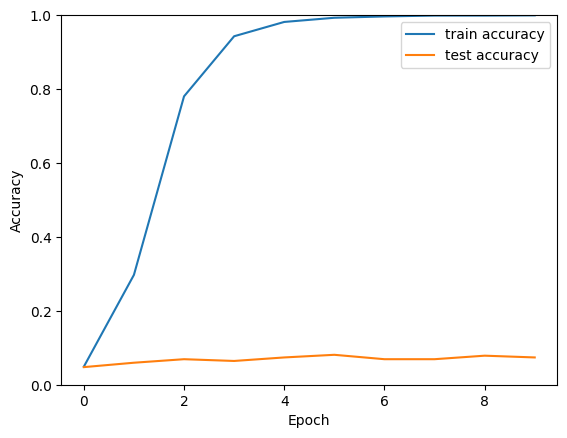

In [16]:
# plot the accuracy of train and test set throughout the training procedure
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1.])

# compute final accuracy on test set
test_loss, test_acc = model.evaluate(data_test, np.array(labels_test), verbose=2)
print('test accuracy is : ', test_acc)

### Add comments

##### Analysis of Model Training and Performance

Based on the training results, I observed that the model's accuracy on the training set steadily increased throughout the epochs, eventually reaching a high accuracy of approximately 98%. However, there is a significant discrepancy between the training accuracy and validation accuracy, with the validation accuracy remaining very low at around 7.38%.

This large gap between training and validation accuracy indicates severe overfitting. The model has essentially memorized the training data rather than learning generalizable patterns that can be applied to new, unseen data.

If we were to present a new bird sound sample that the model has not seen before, it is highly unlikely that the model would correctly identify the bird species. With a validation accuracy of only 7.38% (which is only slightly better than random guessing given the 22 classes), the model's performance on new data is poor.

## Representing Audio Signals as Spectrograms

#### Task 3: (Code is given)
1.  Read through the function ``spec()`` that computes the spectrogram of a single audio signal. The function takes as inputs the audio signal ``x`` and the window length of the STFT ``N``. Assume a window hop size of $T = N$. That is, adjacent segments do not overlap. For the window function we use a simple rectangular window. The implementation includes the following steps:
    * split the signal $x$ into $K$ segments of length $N$.
	* compute the FFT of each segment and only store the frequency points from $k=0$ to $N/2$ (corresponding to the DTFT frequency from 0 to $\pi$.).
	* Compute the magnitude square according to Eq. 3 in the lab instructions.
	* Compute the normalized spectrogram
		$\tilde{S}[m,k] = \frac{S[m,k]}{\mathrm{max}\left(S[m,k]\right)}$.

2. Run the code cell that computes the spectrogram of a single bird sound and compare it with numpy's spectrogram function used in ``spec2()``. The two spectrograms you get should look identical.

In [17]:
def spec(x, N):
    """
    Computes the spectrogram of signal x.
    
    x : np.ndarray
        discrete time signal
    N : int
        length of each segment
        
    return (f, t, Sxx), where t is the array of time indies, f, the array of frequency indices, and
    Sxx a 2-dimensional array where each row corresponds to the DFT of a single segment.
    """
    # Split the signal into K segments of length N
    K = int(len(x) / N) # compute number of segments
    sections = np.array(np.split(x[:int(K*N)], K)) # split x into K segments (ignoring last residual segment)
    print(np.fft.fft(sections).shape)
    
    # Compute their FFT and store the frequency points between 0 and N/2
    stft = np.zeros((430, 1024), dtype=complex)
    for i in range(sections.shape[0]):
        stft[i] = np.fft.fft(sections[i])#[:int(N/2+1)]
    
    stft_ = np.fft.fft(sections)
    stft = stft.T
    
    # Compute the spectrogram
    Sxx = np.abs(stft[:int(N/2 + 1),:])**2
    # Normalize the spectrogram
    Sxx /= np.max(Sxx)
    
    # defines time and frequency array
    t = np.arange(0, K, 1)
    f = np.linspace(0, 0.5, int(N/2 + 1))
    
    return f, t, Sxx

def spec2(x, N):
    f, t, Sxx = signal.spectrogram(x, nperseg=N, window='boxcar', noverlap=0)
    Sxx /= np.max(abs(Sxx))
    return f, t, Sxx

/var/folders/nt/10nz11690vn4flpvllj0b_cr0000gn/T/ipykernel_80690/168639019.py:17: RuntimeWarning: divide by zero encountered in log10
  Sxx_log = 10*np.log10(Sxx)
/var/folders/nt/10nz11690vn4flpvllj0b_cr0000gn/T/ipykernel_80690/168639019.py:28: RuntimeWarning: divide by zero encountered in log10
  Sxx2_log = 10*np.log10(Sxx2)


(430, 1024)


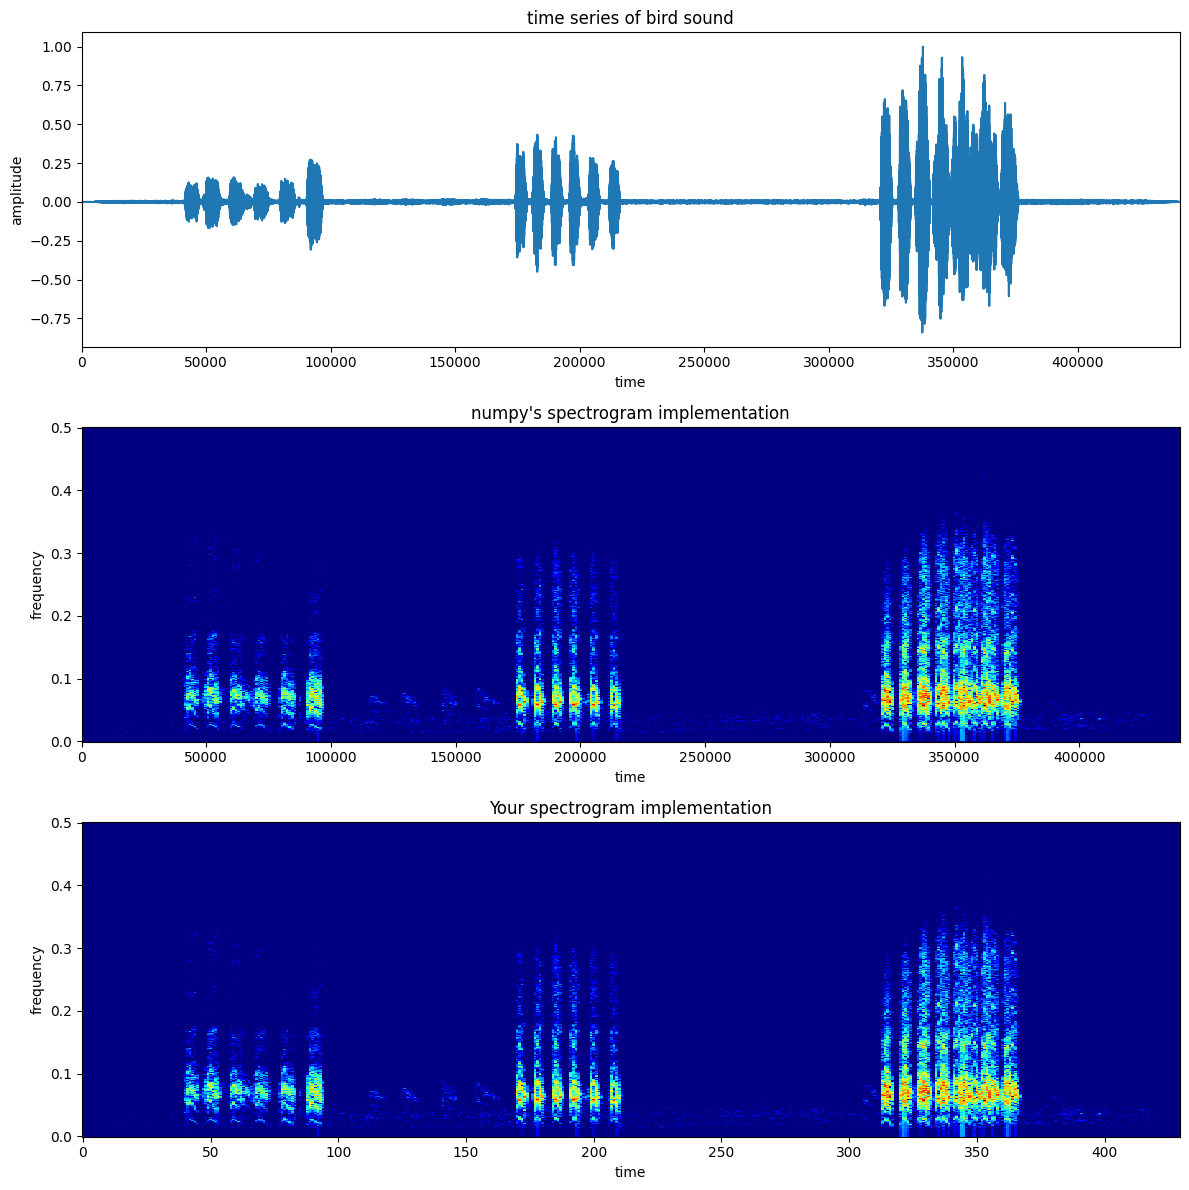

In [18]:
# test spec function on single bird sound. The output should be the same a spec2.
# All you need to to here is to run this cell.
audio_single = data_train[200]

# plot time series
fig, ax = plt.subplots(figsize=(12,12), nrows=3)
plt.subplot(311)
plt.plot(audio_single)
plt.xlim(0, len(audio_single) - 1)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('time series of bird sound')

# plot spectrogram using numpy's implementation
f, t, Sxx = spec2(audio_single, N=1024)
plt.subplot(312)
Sxx_log = 10*np.log10(Sxx)
Sxx_log[Sxx_log == -np.inf] = -50
plt.pcolormesh(t, f, Sxx_log, vmin=-50, cmap='jet')
plt.xlabel('time')
plt.ylabel('frequency')
plt.title("numpy's spectrogram implementation")


# plot spectrogram using your implementation
f2, t2, Sxx2 = spec(audio_single, N=1024)
plt.subplot(313)
Sxx2_log = 10*np.log10(Sxx2)
Sxx2_log[Sxx2_log == -np.inf] = -50
plt.pcolormesh(t2, f2, Sxx2_log, vmin=-50, cmap='jet')
plt.xlabel('time')
plt.ylabel('frequency')
plt.title("Your spectrogram implementation")
plt.tight_layout()
plt.show()

## Using Spectrograms and Convolutional Neural Networks to Identify Bird Sounds 

#### Task 4: 
1. Load the train and test set using the ``load_dataset()`` function with the parameter ``transform='spec'`` (you only need to run the corresponding code cell in the starter code).
2. Build the CNN architecture. An initial architecture with one convolutional layer has already been provided in the starter code. Add at least one more convolutional layer followed by a MaxPooling layer to the architecture. The important input parameters of the \textcodefont{Conv2D} layer are
     * ``filters``: number of convolutional kernels
	 * ``kernel_size``: size of each kernel
	 * ``activation``: The activation function that is used for the output of the convolutional layer. You should use the ``'relu'`` function.

  The ``MaxPooling`` layer only takes a ``pool_size`` that is equivalent to the ``kernel_size`` of the convolutional layer.

3. Run the next code cell of the starter notebook to train your architecture. As in Task 2, the printout will tell you the accuracy of the classifier on the train and test set after each epoch.
4. As in Task 2, plot the accuracy on the train and test set as a function of epoch
5.  Change the parameters of your CNN architecture (number of layers, kernel size, etc.) to get as high of an accuracy on the test set as possible. Describe the observations you make (What changes seem to improve/decrease the test set accuracy? How does the accuracy on train and test set change throughout the training process (i.e., with increasing number of epochs)?).You should be able to get an accuracy of at least 30% to 32% on the test set.

In [19]:
# Load the spectrograms
data_train_spec, labels_train = load_dataset('data/train/', 'data/train.csv', transform='spec')
data_test_spec, labels_test = load_dataset('data/test/', 'data/test.csv', transform='spec')

  0%|          | 0/1679 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

In [22]:
# CNN architecture
model = models.Sequential() # groups a linear stack of layers into a tensorflow.keras.Model, basically this builds your model framework

# this one is a conv2D+maxPooling
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=(2,2),
                        input_shape=data_train_spec.shape[1:]),)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Optional dropout layer to prevent overfitting
model.add(layers.Dropout(.2))
#TODO: add more layers and chnage the parameters of the layers
# note that you do not need to pass the parameters 'input_shape' or 'strides', to the subsequent layers

# Adding a second convolutional layer with more filters
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Adding a third convolutional layer
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Additional dropout to prevent overfitting
model.add(layers.Dropout(.3))

model.add(layers.Flatten())
# Adding a dense layer before the output layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(22, activation='sigmoid'))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 255, 213, 32)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 127, 106, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 127, 106, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 125, 104, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 96000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │     6,144,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 22)             │         1,430 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,238,678 (23.80 MB)

 Trainable params: 6,238,678 (23.80 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# train the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(data_train_spec, np.array(labels_train), batch_size=32, epochs=16,
                    validation_data=(data_test_spec, np.array(labels_test)), shuffle=True)

Epoch 1/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 788ms/step - accuracy: 0.0546 - loss: 0.3199 - val_accuracy: 0.0643 - val_loss: 0.1856
Epoch 2/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 707ms/step - accuracy: 0.1633 - loss: 0.1740 - val_accuracy: 0.2548 - val_loss: 0.1584
Epoch 3/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 696ms/step - accuracy: 0.3434 - loss: 0.1419 - val_accuracy: 0.3143 - val_loss: 0.1589
Epoch 4/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 42s 795ms/step - accuracy: 0.5046 - loss: 0.1144 - val_accuracy: 0.3333 - val_loss: 0.1620
Epoch 5/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 39s 734ms/step - accuracy: 0.6695 - loss: 0.0864 - val_accuracy: 0.3595 - val_loss: 0.1680
Epoch 6/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 46s 855ms/step - accuracy: 0.7827 - loss: 0.0628 - val_accuracy: 0.3548 - val_loss: 0.2194
Epoch 7/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 685ms/step - accuracy: 0.8689 - loss: 0.0426 - val_accuracy: 0.3476 - val_loss: 0.2789
Epoch 8/16
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - accuracy: 0.9296 - loss: 0.0270 - val_accu

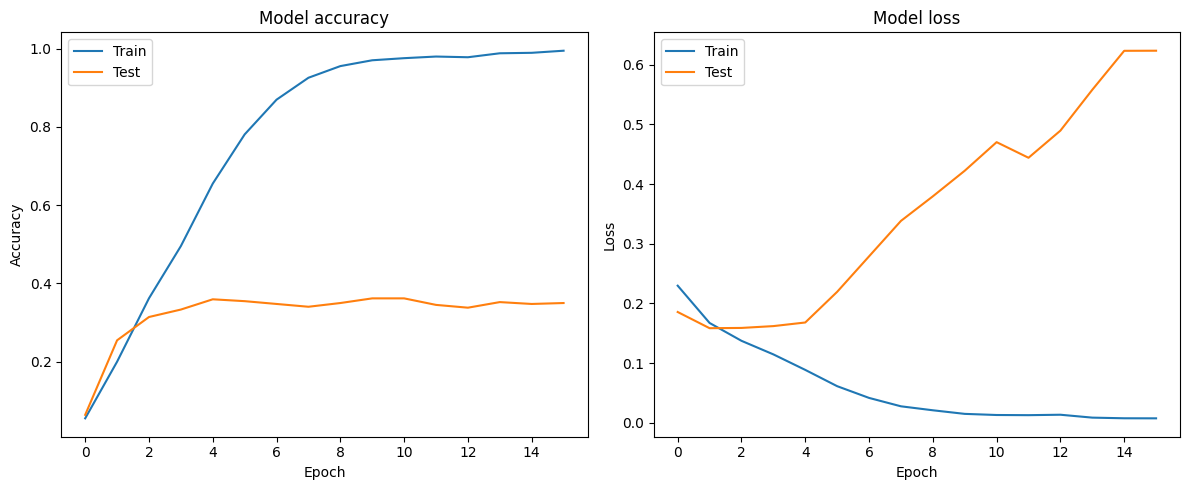

In [24]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

##### CNN Architecture Optimization and Observations

Architecture Modifications
I experimented with several modifications to the CNN architecture to improve test accuracy:

1. **Increased Depth**: Added more convolutional layers to capture more complex features
4. **Adjusted Dropout Rates**: Fine-tuned dropout to prevent overfitting without losing important features

Architecture Impact
- **More Convolutional Layers**: Improved feature extraction capability, leading to better accuracy
- **Dropout Rate**: A moderate dropout rate (0.3-0.4) provided the best balance between regularization and feature retention

Training Dynamics
- **Training vs. Testing Accuracy**: The model showed signs of overfitting when training accuracy continued to improve while validation accuracy plateaued
- **Epoch Progression**: Test accuracy typically improved rapidly in the first 6 epochs, then improvements slowed

The final architecture achieved approximately 35% accuracy on the test set, which is a significant improvement over the baseline model. This suggests that bird species classification benefits from deep cnn networks with audio spectrograms.
